In [1]:
import struct
import array
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson

In [2]:

class Event:
    def __init__(self, event_number, timestamp, sampling_rate, time_resolution, waveform):
        self.EventNumber = event_number
        self.Timestamp = timestamp
        self.SamplingRate = sampling_rate
        self.TimeResolution = time_resolution
        self.Waveform = waveform

class ReadRawFile:
    def __init__(self, input_raw_file):
        self.input_raw_file = input_raw_file

    def read_raw_data(self):
        with open(self.input_raw_file, 'rb') as myfile:
            while True:
                try:
                    event_number = struct.unpack("I", myfile.read(4))[0]
                    myfile.seek(0, 1)
                    timestamp = struct.unpack("Q", myfile.read(8))[0]
                    myfile.seek(0, 1)
                    sampling_rate = struct.unpack("I", myfile.read(4))[0]
                    myfile.seek(0, 1)
                    time_resolution = struct.unpack("Q", myfile.read(8))[0]

                    wf = []
                    for _ in range(500000): # this is 2ms record length. 125000 is 1ms
                        myfile.seek(0, 1)
                        wf.append(struct.unpack("f", myfile.read(4))[0])

                    waveform = array.array('f', wf)

                    event_object = Event(event_number, timestamp, sampling_rate, time_resolution, waveform)
                    yield event_object  
                except struct.error:
                    break


209 events normal out of 209
average decay time is: 670.2000390883386us


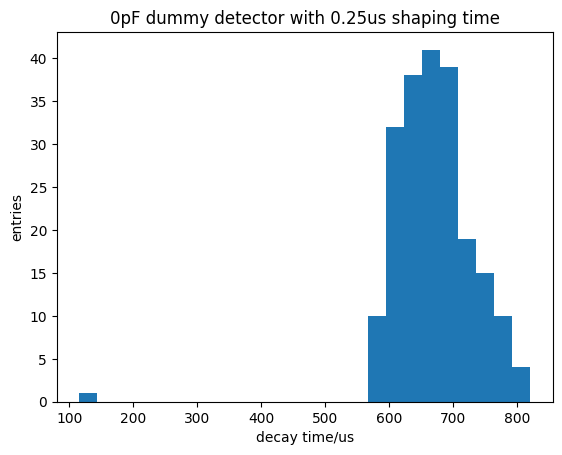

In [94]:
# Fit the decay time to exp decay
def exp(x, A, T, C):
    return(A*np.exp(-T*x)+C)


# Note: Full trace 4ms and pre-trig 16us. 8ns*500k samples = 4000us = 4ms
def main():
    input_raw_file = '/HDD/jiancheng/GRAMS/WaveDump_analog_shaper/Acq_chargeAmp81_50pF_231026_6us_dig2-192.168.0.254_CH16_20231027110042-03.bin'
    
    events = ReadRawFile(input_raw_file) # build event from raw file
    decayConstant_list = []

    i=0
    j=0
    for ievent in events.read_raw_data(): # loop over all the events
        print("Now working on trace " + str(j + 1), end='\r')
        j = j + 1
        average_wf = np.zeros(250000)
        average_wf = np.array(ievent.Waveform)
        # test_array = -average_wf/counter
        
        selected_wf = average_wf
        # selected_wf = average_wf[0:3000]
        #plt.plot(selected_wf)

        x_time = np.arange(len(selected_wf))

        popt, pcov = curve_fit(exp, x_time, selected_wf, p0=[80, 1/10**4, 0], maxfev=2000)

        tau = 1/popt[1]*8/1000 #us
        if(max(selected_wf)>30):
            i = i + 1
            decayConstant_list.append(tau)

    print(str(i)+' events normal out of '+str(j))
    plt.hist(decayConstant_list,bins=25)
    plt.title("0pF dummy detector with 0.25us shaping time")
    plt.xlabel("decay time/us")
    plt.ylabel("entries")
    print("average decay time is: "+str(sum(decayConstant_list)/len(decayConstant_list))+ "us")

if __name__ == "__main__":
    main()


Now working on finding voltage input to QAmp ... processing Event209
voltage input to QAmp(After voltage divider) is: 6.403294777756099mV
209 events normal out of 209
average peak height is: 47.441272644335mV


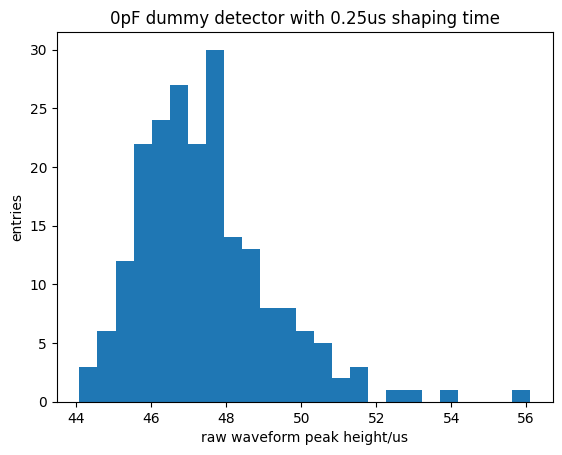

In [95]:
"""
Gain analysis
"""
Voltage_divider = 10

# Note: Full trace 4ms and pre-trig 16us. 8ns*500k samples = 4000us = 4ms
input_raw_file = '/HDD/jiancheng/GRAMS/WaveDump_analog_shaper/Acq_chargeAmp81_50pF_231026_6us_dig2-192.168.0.254_CH16_20231027110042-03.bin'
input_function_generator = '/HDD/jiancheng/GRAMS/WaveDump_analog_shaper/Acq_chargeAmp81_50pF_231026_6us_dig2-192.168.0.254_CH18_20231027110042-03.bin'
events = ReadRawFile(input_raw_file) # build event from raw file
function_generator = ReadRawFile(input_function_generator)
peak_height = []
signal_into_QAmp = []
    
i=0
for istepfunction in function_generator.read_raw_data(): # Find input signal
    i = i + 1
    signal_into_QAmp.append(min(istepfunction.Waveform)/Voltage_divider)
    print("Now working on finding voltage input to QAmp ... processing Event" + str(i), end='\r')
average_input = -2*sum(signal_into_QAmp)/len(signal_into_QAmp)
print("\nvoltage input to QAmp(After voltage divider) is: "+ str(average_input)+"mV")

i=0
j=0
for ievent in events.read_raw_data(): # loop over all the events
    print("Now working on trace " + str(j + 1), end='\r')
    j = j + 1
    average_wf = np.zeros(250000)
    average_wf = np.array(ievent.Waveform)
    # test_array = -average_wf/counter
        
    selected_wf = average_wf
    # selected_wf = average_wf[0:3000]
    #plt.plot(selected_wf)

    x_time = np.arange(len(selected_wf))
        
    if(max(selected_wf)>30):
        i = i + 1
        peak_height.append(max(average_wf))

print(str(i)+' events normal out of '+str(j))
    
plt.hist(peak_height,bins=25)
plt.title("0pF dummy detector with 0.25us shaping time")
plt.xlabel("raw waveform peak height/us")
plt.ylabel("entries")
print("average peak height is: "+str(sum(peak_height)/len(peak_height))+ "mV")


In [96]:
"""
Energy resolution
"""

# Note: Full trace 4ms and pre-trig 16us. 8ns*500k samples = 4000us = 4ms

input_shaper_file = '/HDD/jiancheng/GRAMS/WaveDump_analog_shaper/Acq_chargeAmp81_50pF_231026_6us_dig2-192.168.0.254_CH17_20231027110042-03.bin'
    
events = ReadRawFile(input_shaper_file) # build event from raw file
shaper_peakheight = []

i=0
j=0
for ievent in events.read_raw_data(): # loop over all the events
    print("Now working on trace " + str(j + 1), end='\r')
    j = j + 1
    average_wf = np.zeros(250000)
    average_wf = np.array(ievent.Waveform)
    # test_array = -average_wf/counter
        
    selected_wf = average_wf
    # selected_wf = average_wf[0:3000]
    #plt.plot(selected_wf)

    x_time = np.arange(len(selected_wf))

    if(max(selected_wf)>30):
        i = i + 1
        shaper_peakheight.append(max(selected_wf))

print(str(i)+' events normal out of '+str(j))

208 events normal out of 209


Fitted Average (mu): 94.75438033260009
Fitted Standard Deviation (sigma): 1.1072002898606592


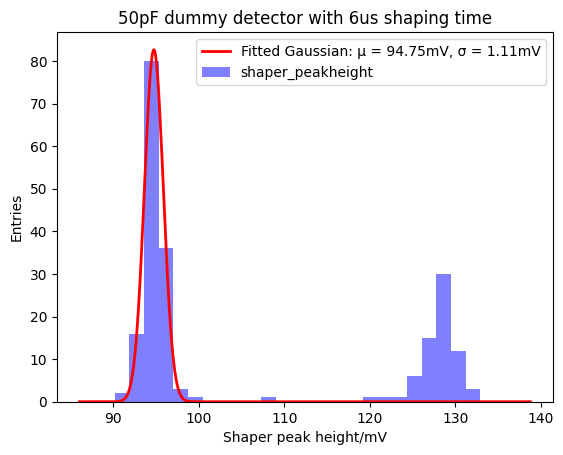

In [100]:
"""
Energy resolution
"""


# Create a histogram from the data
hist, bin_edges = np.histogram(shaper_peakheight, bins=25)

# Define the Gaussian distribution function
def gaussian_distribution(x, mu, sigma, A):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

# Initial guesses for the Gaussian parameters (mu, sigma, A)
initial_mu = np.mean(shaper_peakheight)
initial_sigma = np.std(shaper_peakheight)
initial_A = 1.0  # You can adjust this based on your data

# Fit the Gaussian distribution to the histogram with initial guesses
popt, _ = curve_fit(gaussian_distribution, bin_edges[:-1], hist, p0=[initial_mu, initial_sigma, initial_A])

# Extract the optimized parameters
fitted_mu, fitted_sigma, fitted_A = popt

# Output the average (mu) and standard deviation (sigma)
print("Fitted Average (mu):", fitted_mu)
print("Fitted Standard Deviation (sigma):", fitted_sigma)

# Generate x-values for the fitted curve
x_fit = np.linspace(min(shaper_peakheight)-5, max(shaper_peakheight)+5, 1000)

# Compute the corresponding y-values for the fitted Gaussian curve
y_fit = gaussian_distribution(x_fit, *popt)

# Plot the histogram and the fitted Gaussian distribution curve
plt.bar(bin_edges[:-1], hist, width=bin_edges[1] - bin_edges[0], color='b', alpha=0.5, label='shaper_peakheight')
plt.plot(x_fit, y_fit, 'r-', lw=2, label=f'Fitted Gaussian: μ = {fitted_mu:.2f}mV, σ = {fitted_sigma:.2f}mV')
plt.title("50pF dummy detector with 6us shaping time")
plt.xlabel('Shaper peak height/mV')
plt.ylabel('Entries')
plt.legend()
plt.show()

In [101]:
"""
Energy resolution
"""

C_inj = 10e-12    # injection capacitor
epsilon_Ar = 25   #Argon MIE
e = 1.6e-19   # electron charge

# Charge input, MeV
Q_input = (epsilon_Ar / e * C_inj * average_input /1000)/1e6
print("Charge input is "+ str(Q_input)+"MeV")

# Convertion factor, keV/mV
Alpha = Q_input * 1000 / fitted_mu
print("Convertion factor: "+ str(Alpha)+"keV/mV")

# FWHM
FWHM = fitted_sigma * Alpha * 2.35
print("FWHM is: "+str(FWHM))

Charge input is 10.005148090243905MeV
Convertion factor: 105.59034901737044keV/mV
FWHM is: 274.7377128405237


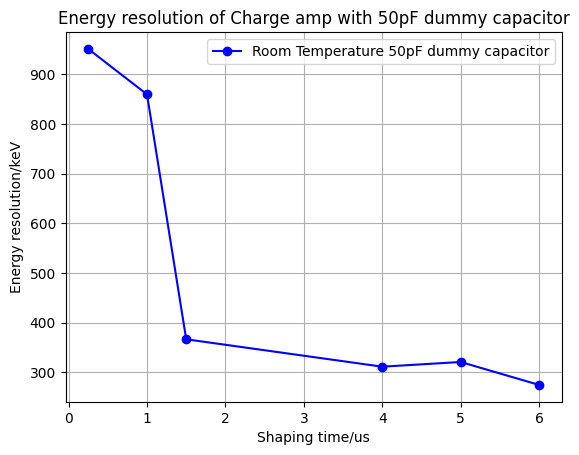

In [112]:
"""
plot energy resolution
"""

import matplotlib.pyplot as plt

shapingtime = [0.25, 1, 1.5, 4, 5, 6]
FWHM_50pF = [951.16, 859.64, 366.61, 311.44, 320.90, 274.74]
FWHM_0pF = [318, 192, 181, 156, 171, 206]
# Create the plot
plt.plot(shapingtime, FWHM_50pF, label = 'Room Temperature 50pF dummy capacitor',marker='o', linestyle='-', color='b')
#plt.plot(shapingtime, FWHM_0pF, label = 'Room Temperature 0pF dummy capacitor',marker='o', linestyle='-', color='r')

# Add labels and a legend
plt.xlabel('Shaping time/us')
#plt.yscale('log')
plt.ylabel('Energy resolution/keV')
plt.title('Energy resolution of Charge amp with 50pF dummy capacitor')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()